In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
%matplotlib inline

In [326]:
toy_data = [[1, "1:3:12", -23.613, -46.0443],
            [1, "1:3:13", -23.613, -46.6443],
            [1, "1:3:50", -23.713, -46.6443],
            [1, "1:4:12", -23.814, -46.6443],
            [1, "1:4:13", -23.613, -46.0443],
            [1, "1:4:50", -23.713, -46.0443],
            [2, "1:3:12", -23.313, -46.9443],
            [2, "1:3:13", -23.513, -46.9443],
            [2, "1:3:50", -23.713, -46.9443],
            [2, "1:4:12", -23.314, -46.9443],
            [2, "1:4:13", -23.513, -46.9443],
            [2, "1:4:50", -23.713, -46.9443]]

columns = ["id", "time", "lat", "lon"]
columns_orig = ["id_orig", "time_orig", "lat_orig", "long_orig"]

In [327]:
df = pd.DataFrame(toy_data, columns=columns)

In [328]:
df.time = pd.to_datetime(df.time, format='%d:%H:%M')#format='%Y-%m-%d %H:%M:%S')

In [329]:
df

,id,time,lat,lon
0,1,1900-01-01 03:12:00,-23.613,-46.0443
1,1,1900-01-01 03:13:00,-23.613,-46.6443
2,1,1900-01-01 03:50:00,-23.713,-46.6443
3,1,1900-01-01 04:12:00,-23.814,-46.6443
4,1,1900-01-01 04:13:00,-23.613,-46.0443
5,1,1900-01-01 04:50:00,-23.713,-46.0443
6,2,1900-01-01 03:12:00,-23.313,-46.9443
7,2,1900-01-01 03:13:00,-23.513,-46.9443
8,2,1900-01-01 03:50:00,-23.713,-46.9443
9,2,1900-01-01 04:12:00,-23.314,-46.9443


<h2>Remove estimated intersections in route:</h2>

In [330]:
def remove_inter(df):
    clean_df = []

    for name, group in df.groupby(["id"]):#, df.time.dt.day]):
        #print(name, group)
        group["cluster"] = (group.time.diff() > pd.Timedelta(minutes=10)).cumsum()
    
        clean_df += [group.groupby(group.cluster).first()]
        #print(group.groupby(group.cluster).first())#.sort_values(group.time).head(1))
        #for name, g in group.groupby(group.cluster):
            #print(name, g)
        #print()
        #print()

    clean = pd.concat(clean_df)
    return clean.drop("cluster", axis=1)

<h2>Estimate Destination:</h2>

In [331]:
def get_OD(clean_df):  
    OD = []
    for name, group in clean_df.groupby(clean_df.id):
        group_dest = group.copy()
        group.columns = columns_orig
        OD += [pd.concat([group, group_dest.shift(-1)], axis=1).drop(["time", "id"], axis=1)] 

    return pd.concat(OD)

get_OD(remove_inter(df))

/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id_orig,time_orig,lat_orig,long_orig,lat,lon
cluster,,,,,,
0,1,1900-01-01 03:12:00,-23.613,-46.0443,-23.713,-46.6443
1,1,1900-01-01 03:50:00,-23.713,-46.6443,-23.814,-46.6443
2,1,1900-01-01 04:12:00,-23.814,-46.6443,-23.713,-46.0443
3,1,1900-01-01 04:50:00,-23.713,-46.0443,NaN,NaN
0,2,1900-01-01 03:12:00,-23.313,-46.9443,-23.713,-46.9443
1,2,1900-01-01 03:50:00,-23.713,-46.9443,-23.314,-46.9443
2,2,1900-01-01 04:12:00,-23.314,-46.9443,-23.713,-46.9443
3,2,1900-01-01 04:50:00,-23.713,-46.9443,NaN,NaN


<h2>Clustering Metric:</h2>

In [332]:
def bundling_metric(X):
    
    def pairwise(l1,l2):
        
        return np.sum(np.dot(np.sum(np.square(l1 - l2)),
                             np.log(1 + np.abs((l1[:2] - l2[:2])**2 - (l1[2:] - l2[2:])**2))))
    
    return cdist(X, X, metric=pairwise)

<h2>Clustering</h2>

In [333]:
def get_clusters(X, n_clusters, metric):
    X = metric(X)
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="average", affinity='precomputed')
    model.fit(X)
    
    #X[model.labels_ == l]
    
    return model.labels_

In [334]:
def cluster(df, n_clusters):
    df = df.dropna(axis=0, how='any')
    clustered = []
    for name, group in df.groupby([df.time_orig.dt.hour]):
       
        group["cluster"] = get_clusters(group.loc[:,"lat_orig":"lon"].values, n_clusters, bundling_metric)
        
        grouped = group.groupby(group.cluster)
        representative = grouped.first()
        representative["count"] = grouped.size()
        clustered += [representative]
    #return pd.concat(clustered)
    return clustered

In [335]:
def plot_cluster(cluster):
    
    ax = cluster.plot.scatter("lat_orig", "long_orig")
    cluster.plot.scatter("lat", "lon", ax=ax)
    plt.show()
    

/home/luke/freya_home/luke/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


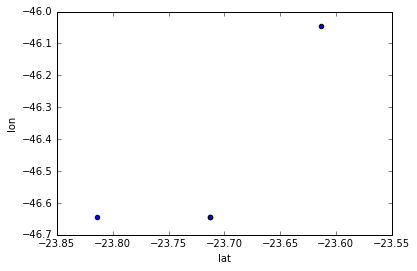

In [336]:
clusters = cluster(get_OD(remove_inter(df)), 2)
plot_cluster(clusters[0])

In [337]:
def cluster_on_map(cluster):
    m = folium.Map(location=[cluster.lat.mean(), cluster.lon.mean()])
    colors = ["green","blue", "red", "orange", "brown", "yellow", "white"]
    i = 0
    for index, row in cluster.iterrows():
        
        folium.features.PolyLine([row.loc["lat_orig":"long_orig"].values.tolist(),
                                   row.loc["lat":"lon"].values.tolist()], color=colors[i], weight=row["count"]).add_to(m)
        i+=1
    return m

In [338]:
cluster_on_map(clusters[0])

=top - 01:47:37 up 14:05,  5 users,  load average: 3,00, 2,62, 2,58
Tasks: 231 total,   1 running, 230 sleeping,   0 stopped,   0 zombie
%Cpu(s): 55,9 us,  0,5 sy,  0,0 ni, 42,8 id,  0,7 wa,  0,0 hi,  0,0 si,  0,0 st
KiB Mem:   8072044 total,  5605884 used,  2466160 free,   304320 buffers
KiB Swap: 24082424 total,        0 used, 24082424 free.  2208844 cached Mem

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
 2918 luke      20   0  878252 135016  54408 S  94,4  1,7   1:24.15 chrome      
 2703 luke      20   0  559560 178928 106376 S  18,9  2,2  12:17.10 chrome      
 5198 luke      20   0 1497328 721728 574536 S  18,9  8,9  19:37.97 chrome      
 2609 luke      20   0 2080380 435848 150108 S  12,6  5,4  21:16.82 chrome      
 1105 root      20   0  289772  43204  32640 S   6,3  0,5   7:11.18 Xorg        
 3032 luke      20   0 2366388 211152  54416 S   6,3  2,6   1795:49 chrome      
    1 root      20   0   33920   4436   2692 S   0,0  0,1   0:01.